In [112]:
import pandas as pd
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


data = pd.read_csv('../data/transformed_data/all_time_series.csv', index_col=0)

In [113]:
# define dickey fuller test function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput['p-value']    


In [114]:
for column in data.columns:
    data[column + '_diff'] = data[column].diff().dropna()
    print(f'Testing stationarity for {column}')
    result = test_stationarity(data[column + '_diff'].dropna())
    print(f'p-value: {result} for {column}')



Testing stationarity for art
Results of Dickey-Fuller Test:
p-value: 0.00026032936003619666 for art
Testing stationarity for hype
Results of Dickey-Fuller Test:
p-value: 0.0001115885419042548 for hype
Testing stationarity for gf_index
Results of Dickey-Fuller Test:
p-value: 2.022124487083598e-30 for gf_index
Testing stationarity for spy
Results of Dickey-Fuller Test:
p-value: 2.1233678508941067e-30 for spy


In [102]:
import statsmodels.api as sm

# Assuming 'data' is your DataFrame
# Select appropriate columns
selected_columns = [ 'art_diff', 'hype_diff',
       'gf_index_diff', 'spy_diff']  # Fill with names of columns to use
data_svar = data[selected_columns]

# add svar dummy column
# drop all NaN values
data_svar = data_svar.dropna()

# determine optimal lag
model = sm.tsa.VAR(data_svar)
lag_results = model.select_order(2)
lag_order = lag_results.hqic





/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [103]:
import numpy as np
import statsmodels.api as sm

# Assuming 'data_svar' is your DataFrame with the time series
data_svar = data[['art_diff', 'hype_diff', 'gf_index_diff', 'spy_diff']]
data_svar['sothebys_shock'] = 0
data_svar.loc[data_svar.index == '2023-06-15', 'sothebys_shock'] = 1

data_svar.dropna(inplace=True)
# Correctly define the A matrix based on the relationships
A = np.array([
    [1, 'E', 'E', 'E', 0],  # art_diff
    ['E', 1, 'E', 'E', 0],  # hype_diff
    [0, 0, 1, 0, 0],        # gf_index_diff
    ['E', 'E', 0, 1, 0],    # spy_diff
    ['E', 'E', 0, 0, 1]         # shock_art_diff
]
)
# Create the SVAR model instance
model = sm.tsa.SVAR(data_svar, svar_type='A', A=A)

# Fit the model
results = model.fit(solver='nm')

results.k_exog_user = 0 # https://github.com/statsmodels/statsmodels/issues/8025
# Print the summary
results.summary()

/var/folders/rp/1xxr_95d09j_t6cjf0dp36bh0000gn/T/ipykernel_19376/3521350477.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_svar['sothebys_shock'] = 0
/var/folders/rp/1xxr_95d09j_t6cjf0dp36bh0000gn/T/ipykernel_19376/3521350477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_svar.dropna(inplace=True)
/Users/simon/Documents/Uni/Statistic/Semester 6/svar-causal/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates,

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 18, Jan, 2024
Time:                     16:58:02
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   0.184084
Nobs:                     359.000    HQIC:                -0.0113823
Log likelihood:          -2491.79    FPE:                   0.869000
AIC:                    -0.140428    Det(Omega_mle):        0.799885
--------------------------------------------------------------------
Results for equation art_diff
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.072351         0.237212           -0.305           0.760
L1.art_diff               0.350810         0.048683            7.206           0.000
L1.hype_diff              0.420105       

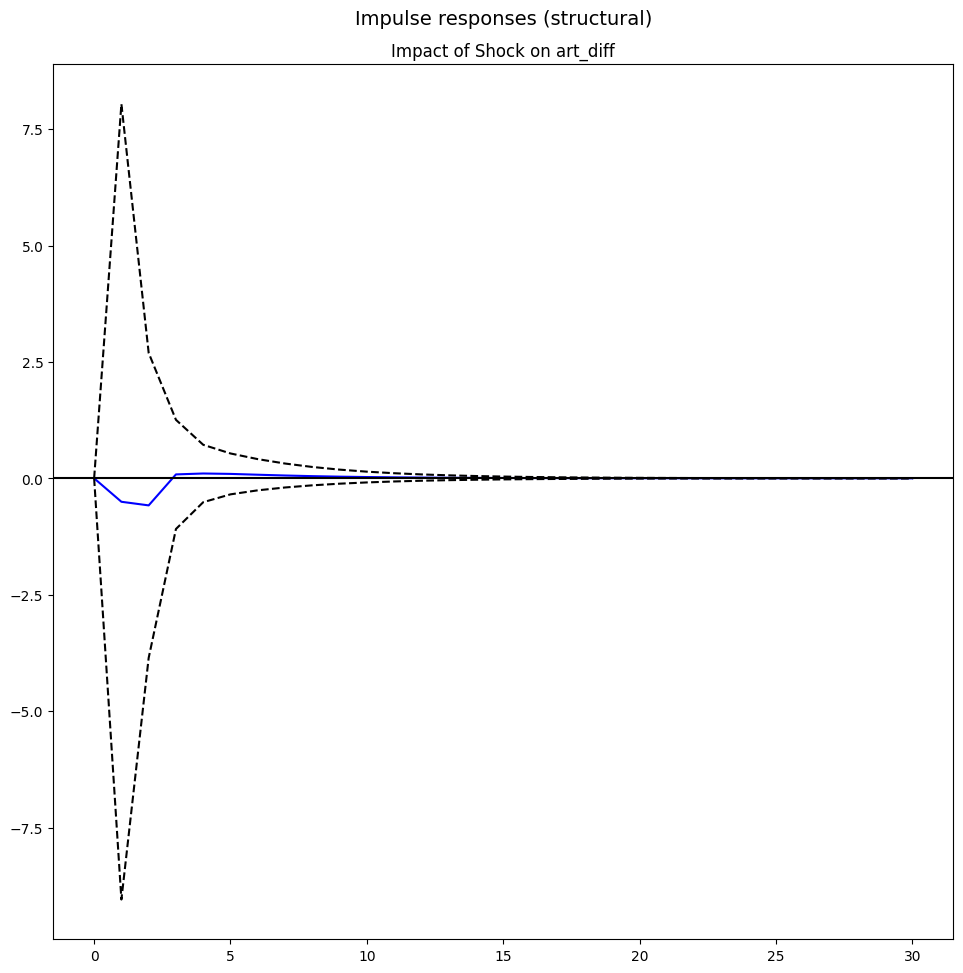

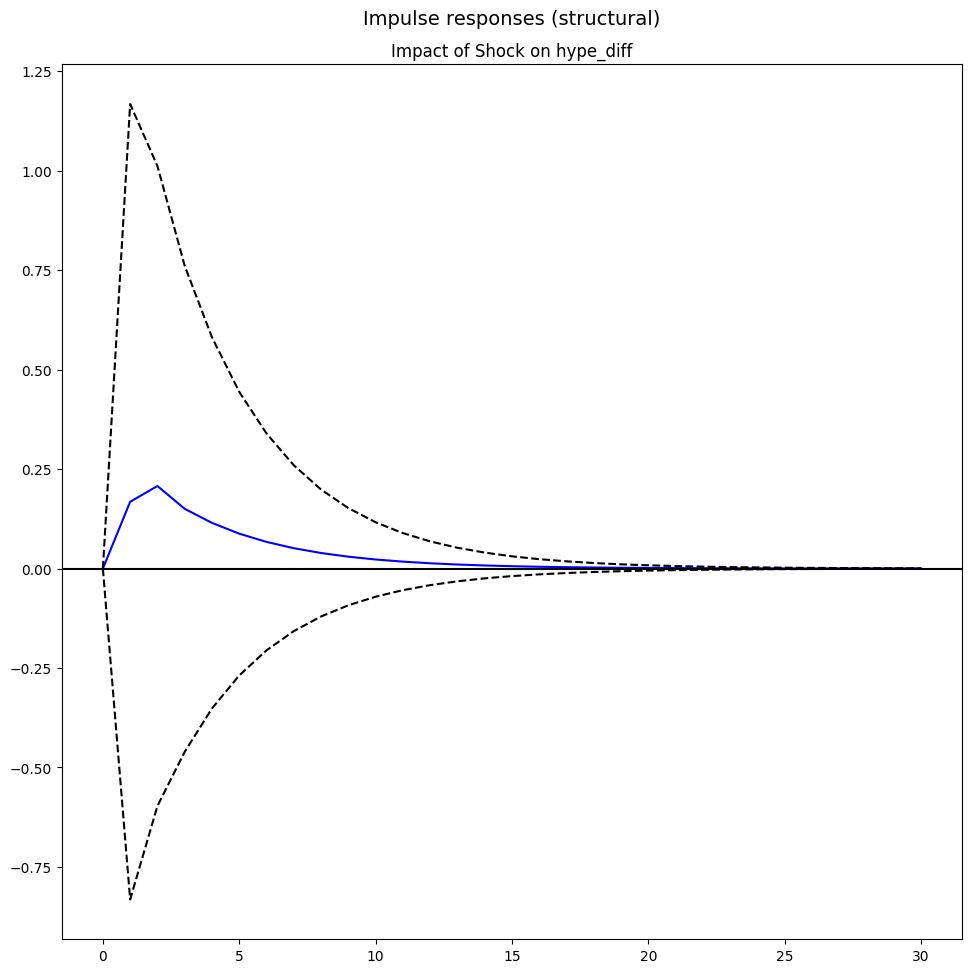

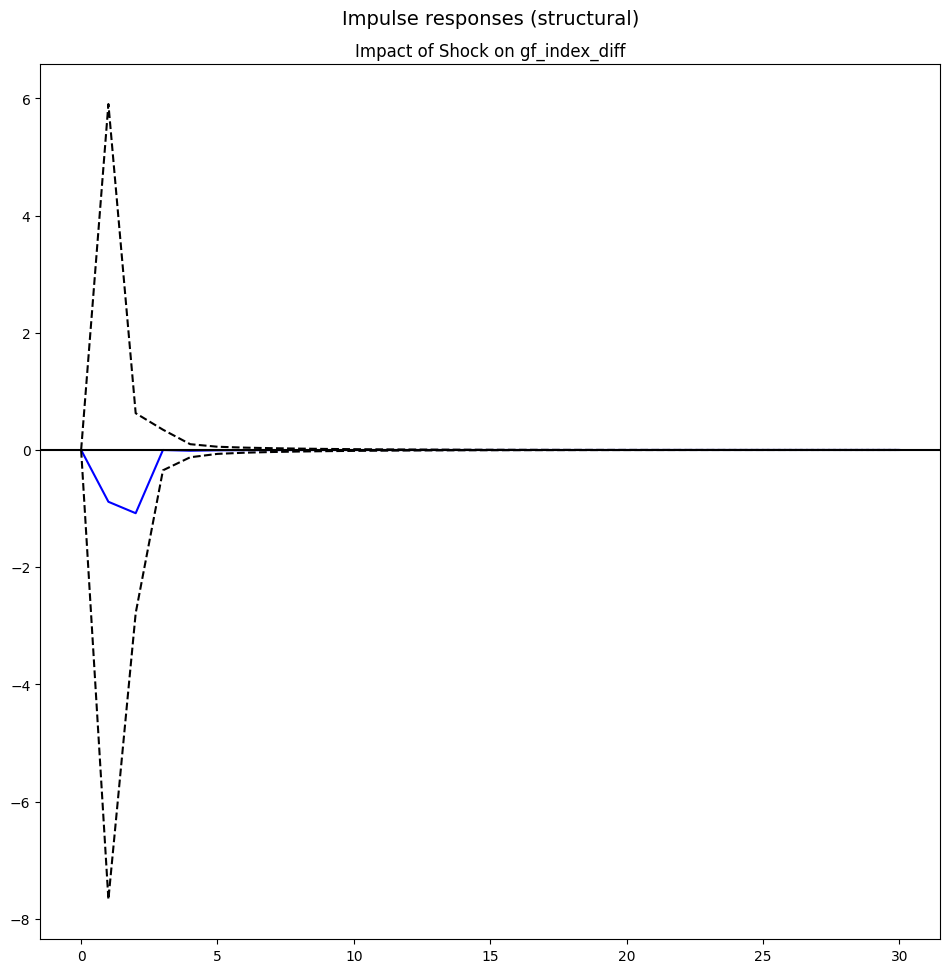

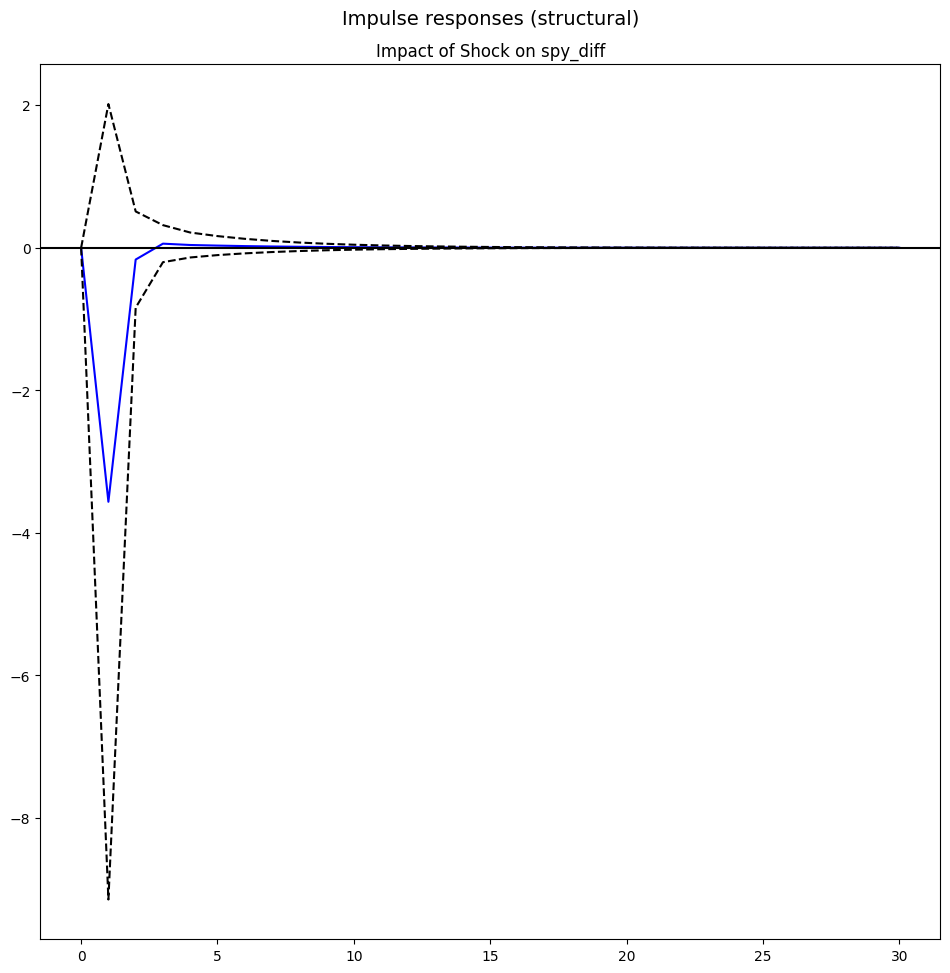

In [107]:
import matplotlib.pyplot as plt

# Number of periods to forecast
periods = 30

# Generate impulse response functions
irf = results.irf(periods)

# Plot the impulse responses of all variables to the shock in the dummy variable
# Assuming the dummy variable is the last one in your model
for i in range(len(data_svar.columns) - 1):  # Exclude the dummy itself
    irf.plot(impulse=len(data_svar.columns) - 1, response=i)
    plt.title(f'Impact of Shock on {data_svar.columns[i]}')
    plt.show()


In [111]:
results.plot_forecast(periods=30, plot_stderr=False)

TypeError: VARResults.plot_forecast() got an unexpected keyword argument 'periods'